<a href="https://colab.research.google.com/github/raneldan/Ransomware-Detection/blob/main/Ransomeware_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import & Installs
from google.colab import drive
import os
import csv

import sys

import numpy as np
import matplotlib.pyplot as plt
import imblearn
from imblearn.over_sampling import SMOTE


# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib




drive.mount('/content/gdrive')

!sudo pip install imbalanced-learn


Mounted at /content/gdrive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# THIS IS THE BASE PATH, ALL OTHER PATHS IS RELATIVE TO THIS ONE
# THIS PATH SHOULD BE PRE-EXIST IN GOOGLE DRIVE 
basePath = "/content/gdrive/MyDrive/Colab Notebooks/Ransomeware-Project"

In [ ]:
# Implementation of perceptron classifier 

def step_func(z):
    return 1.0 if (z > 0) else 0.0


def perceptron(X, y, lr, epochs):
    
    # X --> Inputs.
    # y --> labels/target.
    # lr --> learning rate.
    # epochs --> Number of iterations.
    
    # m-> number of training examples
    # n-> number of features 
    m, n = X.shape

    # Initializing parapeters(theta) to zeros.
    # +1 in n+1 for the bias term.
    theta = np.zeros((n+1,1))
    
    # Empty list to store how many examples were 
    # misclassified at every iteration.
    n_miss_list = []
    
    # Training.
    for epoch in range(epochs):
        
        # variable to store #misclassified.
        n_miss = 0
        
        # looping for every example.
        for idx, x_i in enumerate(X):
            
            # Insering 1 for bias, X0 = 1.
            x_i = np.insert(x_i, 0, 1).reshape(-1,1)
            
            # Calculating prediction/hypothesis.
            y_hat = step_func(np.dot(x_i.T, theta))
            
            # Updating if the example is misclassified.
            if (np.squeeze(y_hat) - y[idx]) != 0:
                theta += lr*((y[idx] - y_hat)*x_i)
                
                # Incrementing by 1.
                n_miss += 1
        
        # Appending number of misclassified examples
        # at every iteration.
        n_miss_list.append(n_miss)
        
    return theta, n_miss_list

# This function classify the data with the perceptron classifier
def classify(data, theta):
  data = np.insert(data, 0, 1).reshape(-1,1)
  y_hat = step_func(np.dot(data.T, theta))
  return (np.squeeze(y_hat))

In [ ]:
 # Function to help visualize  the feature space (only the first 2 features displayed)
 # I used this function to find and eliminate outliers
 def plot_decision_boundary(X, theta):
    # X --> Inputs
    # theta --> parameters
    
    # The Line is y=mx+c
    # So, Equate mx+c = theta0.X0 + theta1.X1 + theta2.X2
    # Solving we find m and c
    x1 = [min(X[:,0]), max(X[:,0])]
    m = -theta[1]/theta[2]
    c = -theta[0]/theta[2]
    x2 = m*x1 + c

    
    fig = plt.figure(figsize=(10,8))
    plt.ylim([0, 1])
    # Legitimate programs are marked as blue squares
    plt.plot(X[:, 0][train_labels==0], X[:, 1][train_labels==0], "bs")
    # Ransomwares are marked as red traingle
    plt.plot(X[:, 0][train_labels==1], X[:, 1][train_labels==1], "r^")
    plt.xlabel("feature 1")
    plt.ylabel("feature 2")
    plt.title("Perceptron Algorithm")
    plt.plot(x1, x2, 'y-')

In [ ]:
# Function thats gets listes of files path inside the Google Drive and return just the files name (trim the path)
def getFilesNames(files):
  result = []
  for file in files:
    file = file.split('/')
    result.append(file[-1])
  return result

# Fucntion that prints for each files it's name and the features extracted from the file
def printFeatures(files, X):
  for file, x in zip(files,X):
    file = [file]
    printFilesName(file)
    print(x)

# Function that get a path to a files and print its name
def printFilesName(files):
  for file in files:
    file = file.split('/')
    print(file[-1])

# Help function to count the number of samples used during the training and testing
def numberOfSamples(files):
  legit = 0
  ransomeware = 0
  for file in files:
    # Ransomewar samples are marked with legit in the file name
    if ("legit" in file):
      legit += 1
    else:
      ransomeware += 1
  return ("Number of ransomeware samples : {} \n Number of legit samples : {}".format(ransomeware, legit))

In [ ]:
# All of windows API calls are store in a file
# This function create a list of all the operations
def getOperationList():
  operationList = []
  operationListFile = basePath + "/resources/Proc mon operation list.txt"
  with open(operationListFile, "r") as f:
    for line in f:
      line = line.strip('\n')
      operationList.append(line)
  return (operationList)

In [ ]:
# Importing the operation list from the file
operationList = getOperationList()

In [ ]:
# FEATURE FUNCTIONS
# Each function used to generate a feature

# This function recive an operation (as string) and return the enum value associated to it
def convertOperationToNum(op):
  return operationList.index(op)

# Funciton to find the number of unique operation. The input is list of operations. The result is used as a feature.
def numOfUniqueOperations(operation):
  return (len(set(operation)))

# Funciton to find the max time to complete any operation. The input is list of times. The result is used as a feature.
def maxCompletionTime(times):
  return (max(times,key=lambda x:float(x)))

# Funciton to find the mean time to complete operation. The input is list of times. The result is used as a feature.
def meanCompletionTime(times):
  return(np.mean(times))

# Funciton to find the ratio of successful operations vs failed operations. The input is list of the results of the operations. The result is used as a feature.
def percentageOfFailedResult(results):
  return(results.count("SUCCESS")/len(results))

# Funciton to find the ratio of I/O operations from all the opertaions. The input is list of the results of the operations. The result is used as a feature.
def percentageOfIOEventClass(classes):
  return(classes.count("File System")/len(classes))

# Funciton to find the total amount of operations recorded. The input is list of the results of the operations. The result is used as a feature.
def numOfOperations(operation):
  return (len(operation))

# Generic function that recieve an operation and find the ratio of the operation in the operation list
def percentOfOperation(operation, operationToSearch):
  sum = 0
  for op in operation:
    if (op == operationToSearch):
      sum += 1
  return (sum/len(operation))

In [ ]:
# This function create the correct tags for all the files in the given path
def createTags(files):
  y = []
  for file in files:
    # samples tagged legit in the file name if they normal programs. otherwise - the tag is ransomeware
    if ("legit" in file):
      y.append(0)
    else:
      y.append(1)
  return(np.array(y))
  
# Function that compare the predictions of the classifier vs the true lables and returns the accuracy
def compareTags(prediction, truth):
  numOfMisMatch = 0
  for p,t in zip(prediction, truth):
    if (p != t):
      numOfMisMatch += 1
  return ((len(prediction) - numOfMisMatch) / len(prediction))

In [ ]:
# This function extract the features from the given files.
# We iterate file by file and create vectors (opertion, times, etc..) of the events that stored in the file.
# Later, we used the previous functions to create features from this vectors.
def extractFeatures(files):
  NUM_OF_SAMPLES = len(files)
  X = np.zeros([NUM_OF_SAMPLES, NUM_OF_FEATURES], dtype=float)
  for index,file in enumerate(files):
    with open(file, "r") as f:
      reader = csv.reader(f, delimiter=",")
      operations = [] 
      times = []
      results = []
      classes = []
      for i, line in enumerate(reader):
        # skip first line because it contains headers
        if (i != 0 and len(line) > 2):
          operations.append(convertOperationToNum(line[3]))
          results.append(line[5])
          # edge cases where data is curropted
          if (len(line) >= 8):
            times.append(float(line[7]))
            classes.append(line[8])
          else:
            # fill it with default values
              times.append(0.0)
              classes.append("")

    # fill feature matrix with data
    X[index][0] = numOfUniqueOperations(operations)
    X[index][1] = percentageOfFailedResult(results)
    X[index][2] = maxCompletionTime(times)
    X[index][3] = meanCompletionTime(times)
    X[index][4] = percentageOfIOEventClass(classes)
    #X[index][5] = numOfOperations(operations)
    X[index][5] = percentOfOperation(operations, 6) # LOAD_IMAGE = 6
    X[index][6] = percentOfOperation(operations, 18) # QUERY_DIR = 18

  return X

Logfile visual studio code legit.CSV
[60 0.759558 178.667 0.0111424 0.46288 0.00545567 0.0261425]
Logfile cerber extended.CSV
[37 0.89423 0.11332 0.000135277 0.880322 0.000426597 0.0197314]
Logfile permier crack.CSV
[32 0.938132 0.04787 1.86409e-05 0.944496 0.000763714 0.0576422]
Logfile sick.CSV
[26 0.852461 3.3116 0.000942415 0.981292 0.000288133 0.17931]
Logfile bagli.CSV
[36 0.863276 0.0320758 3.36147e-05 0.666776 0.00155853 0.0332068]
Logfile - acuna.CSV
[42 0.870575 0.276149 0.000233768 0.953814 0.00085765 0.294449]
Logfile note legit.CSV
[48 0.758325 0.0479386 1.32607e-05 0.147229 0.00187077 0.00160886]
Logfile conti.CSV
[38 0.887073 0.161508 5.5443e-05 0.990537 6.58039e-05 0.0888943]
Logfile 2048 legit.CSV
[51 0.863189 0.404901 2.68658e-05 0.659916 0.0036836 0.00230663]
Logfile armagedon legit.CSV
[40 0.712366 0.0106505 7.96324e-06 0.335403 0.0029259 0.00740431]
Logfile nefilim.CSV
[27 0.936441 0.515118 0.000107011 0.997124 0.000104665 0.0305676]
Logfile wannacry.CSV
[39 0.8549

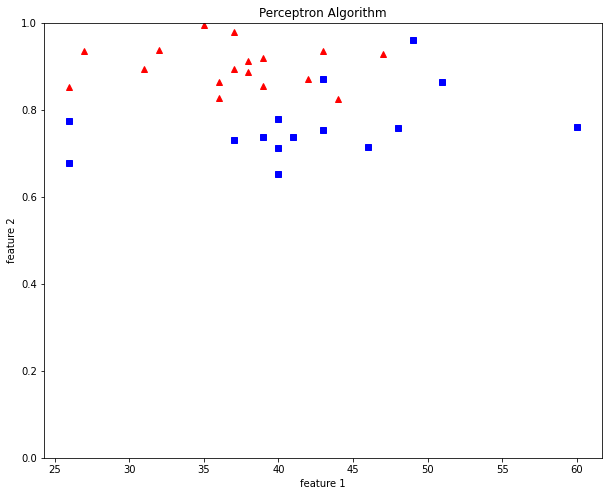

In [ ]:
# Training process #

trainPath = basePath + '/train/'
# Constant that hold dim of the feature vector
NUM_OF_FEATURES = 7
files = [trainPath + x for x in os.listdir(trainPath)]
train_features = extractFeatures(files) 
# Formating for printing purpose
np.set_printoptions(formatter={"float_kind": lambda x: "%g" % x})
# Creating the tags of the samples
train_labels = createTags(files)
# Normalize the features 
#train_mean = np.mean(train_features, axis=0)
#train_std = np.std(train_features, axis=0)
#train_features = (train_features - train_mean) / train_std
# Debug
printFeatures(files, train_features)
print(train_labels)
print(numberOfSamples(files))
# Run the perceptron on the data
T, ml = perceptron(train_features, train_labels, 0.05, 100000)
print("Accuracy on train set", (len(files)-ml[-1])/len(files))
# Print the graph of the samples and features
plot_decision_boundary(train_features, T)



In [ ]:
# Testing process #

# This process is almost identical to the training process
testPath = basePath + '/test/'
files = [testPath + x for x in os.listdir(testPath)]
printFilesName(files)
test_features = extractFeatures(files)
# Normalize the features 
#train_mean = np.mean(train_features, axis=0)
#train_std = np.std(train_features, axis=0)
#train_features = (train_features - train_mean) / train_std
print(test_features)
print(numberOfSamples(files))
predictions = []
test_labels = createTags(files)

for testFile in test_features:
  predictionResult = classify(testFile,T)
  predictions.append(predictionResult)
  print(predictionResult)
print("Accuracy on test set" , compareTags(predictions, test_labels))

Logfile duplicate files legit.CSV
Logfile atomic tanks legit.CSV
Logfile mincraft.CSV
Logfile blackmatter.CSV
Logfile CrystalDiskMark legit.CSV
Logfile cryptolocker.CSV
Logfile wannacry2.CSV
Logfile babuk locker.CSV
Logfile revil kaseya.CSV
Logfile darkside2.CSV
Logfile tocan legit.CSV
Logfile chess legit.CSV
Logfile audacity legit.CSV
Logfile camstudio legit.CSV
Logfile diskcleaner legit.CSV
[[27 0.741505 0.0870234 6.49595e-05 0.185376 0.00283989 0.050661]
 [26 0.869868 0.0037301 1.69985e-05 0.569229 0.00843978 0.00228102]
 [41 0.954144 0.132837 1.08603e-05 0.851539 0.000122234 1.40624e-05]
 [42 0.929382 15.7309 0.0618691 0.987602 0.000230777 0.0147377]
 [44 0.790272 4.83323 0.000751027 0.459496 0.00203449 0.00082619]
 [40 0.83175 0.271699 9.87844e-05 0.973855 9.96561e-05 0.338589]
 [36 0.795911 0.276881 0.00011237 0.941972 0.000116343 0.0663387]
 [35 0.942045 0.842547 0.000915549 0.874541 0.000474181 0.0492153]
 [41 0.903057 1.63557 0.00613739 0.883002 0.000478087 0.0274506]
 [30 0.8

In [ ]:
# Create syntetic samples using SMOTE
oversample = SMOTE(random_state=0)
train_features, train_labels = oversample.fit_resample(train_features, train_labels)
# Normalize the features 
train_mean = np.mean(train_features, axis=0)
train_std = np.std(train_features, axis=0)
train_features_norm = (train_features - train_mean) / train_std

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               800       
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 901
Trainable params: 901
Non-trainable params: 0
_________________________________________________________________
None
2

............................................................
        loss  binary_accuracy  val_loss  val_binary_accuracy  epoch
0   0.670913         0.370370  0.720541             1.000000      0
1   0.657231         0.370370  0.717227             1.000000      1
2   0.643809         0.370370  0.714088             1.000000      2
3   0.630656         0.407407  0.711121             1.000000      3
4   0.617799         0.407407  0.708236      

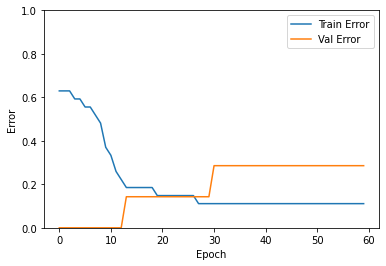

In [ ]:
# This funciton create the network 
def build_model():
    model = keras.Sequential([
        Dense(100, activation=tf.nn.relu, input_shape=[NUM_OF_FEATURES]),
        Dense(1)
    ])

    model.compile(optimizer = tf.optimizers.Adam(), 
                  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics = tf.keras.metrics.BinaryAccuracy())
    return model

# This helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

model = build_model()
# Debug
print(model.summary())
print(len(model.layers))

# Regulate the model complexity using early stop method to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)
history = model.fit(train_features_norm, train_labels, epochs=1000, verbose=0, validation_split = 0.2,
                    callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print()
print(hist)

# Print the result of the traning
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.plot(hist['epoch'], 1-hist['binary_accuracy'], label='Train Error')
    plt.plot(hist['epoch'], 1-hist['val_binary_accuracy'], label = 'Val Error')
    plt.legend()
    plt.ylim([0,1])

plot_history()

In [ ]:
# Get the prediction for the testing set and output the accuracy
test_features_norm = (test_features - train_mean) / train_std
mse, _ = model.evaluate(test_features_norm, test_labels)

1/1 [==============================] - 0s 18ms/step - loss: 0.3251 - binary_accuracy: 0.9333


In [ ]:

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
0
regressor = RandomForestClassifier(n_estimators=2, random_state=42)
regressor.fit(train_features, train_labels)
y_pred = regressor.predict(test_features)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, y_pred)))

print (y_pred)
print(classification_report(test_labels,y_pred))
print(accuracy_score(test_labels, y_pred))

Mean Absolute Error: 0.13333333333333333
Mean Squared Error: 0.13333333333333333
Root Mean Squared Error: 0.3651483716701107
[0 0 0 1 0 1 1 1 1 1 1 0 0 0 0]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.86      0.86      0.86         7

    accuracy                           0.87        15
   macro avg       0.87      0.87      0.87        15
weighted avg       0.87      0.87      0.87        15

0.8666666666666667


In [ ]:
from sklearn import svm
svmClassifier = svm.NuSVC()
svmClassifier.fit(train_features, train_labels)
y_pred = svmClassifier.predict(test_features)
print (y_pred)
print(classification_report(test_labels,y_pred))
print(accuracy_score(test_labels, y_pred))

[0 0 0 1 1 1 1 1 1 1 0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.86      0.86      0.86         7

    accuracy                           0.87        15
   macro avg       0.87      0.87      0.87        15
weighted avg       0.87      0.87      0.87        15

0.8666666666666667
